In [1]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Sine(nn.Module):
    def __init__(self, w0=1.):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)


class BModel(nn.Module):

    def __init__(self, in_coords, out_values, dim):
        super().__init__()
        self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(8)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, out_values)
        self.activation = Sine()  # torch.tanh

    def forward(self, x):
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        x = self.d_out(x)
        return x

In [3]:
model = BModel(3, 3, 256)

In [4]:
from torch.utils.data import Dataset, DataLoader, RandomSampler
import numpy as np

In [5]:
sss = 'B.npy'

In [6]:
b_slices = np.load(sss)

In [7]:
b_slices.shape

(512, 256, 256, 3)

In [8]:
coords = np.stack(np.mgrid[:b_slices.shape[0], :b_slices.shape[1], :b_slices.shape[2]], -1).astype(np.float32)
coords.shape

(512, 256, 256, 3)

In [9]:
coords = coords.reshape((-1, 3)).astype(np.float32)
values = b_slices.reshape((-1, 3)).astype(np.float32)

In [10]:
coords.shape

(33554432, 3)

In [11]:
values.shape

(33554432, 3)

In [12]:
cube_shape = b_slices.shape
cube_shape

(512, 256, 256, 3)

In [13]:
cube_shape = np.array([[0, cube_shape[0] - 1], [0, cube_shape[1] - 1], [0, cube_shape[2] - 1]])

In [14]:
class MyDataset(Dataset):
    def __init__(self, data_path, b_norm, spatial_norm, slices, boundary_batch_coords, random_batch_coords):
        self.data_path = data_path
        self.b_norm = b_norm
        self.spatial_norm = spatial_norm
        self.slices = slices
        self.boundary_batch_coords = int(boundary_batch_coords)
        self.random_batch_coords = int(random_batch_coords)
        self.float_tensor = torch.FloatTensor

    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        b_slices = np.load(self.data_path)

        b_slices = b_slices[:, :, self.slices, :]

        coords = np.stack(np.mgrid[:b_slices.shape[0], :b_slices.shape[1], :b_slices.shape[2]], -1).astype(np.float32)
        coords = coords.reshape((-1, 3)).astype(np.float32)
        values = b_slices.reshape((-1, 3)).astype(np.float32)

        coords = coords / self.spatial_norm
        values = values / self.b_norm

        cube_shape = b_slices.shape
        cube_shape = np.array([[0, cube_shape[0] - 1], [0, cube_shape[1] - 1], [0, cube_shape[2] - 1]])

        random_coords = self.float_tensor(self.random_batch_coords, 3).uniform_()
        random_coords[:, 0] = (random_coords[:, 0] * (cube_shape[0, 1] - cube_shape[0, 0]) + cube_shape[0, 0])
        random_coords[:, 1] = (random_coords[:, 1] * (cube_shape[1, 1] - cube_shape[1, 0]) + cube_shape[1, 0])
        random_coords[:, 2] = (random_coords[:, 2] * (cube_shape[2, 1] - cube_shape[2, 0]) + cube_shape[2, 0])
        random_coords = random_coords / self.spatial_norm

        #--- pick one data
        r = np.random.choice(coords.shape[0], self.boundary_batch_coords)
        coords = coords[r]
        values = values[r]
        
        samples = {'random_coords': random_coords,
                   'coords': coords,
                   'values': values}

        return samples
    

In [15]:
spatial_norm = 255
b_norm = 2500
num_coords = 2e4
num_random_coords = 1e4

slices = [0, 1, 2, 3, 4, 5, 10, 50, 100, 200]

In [16]:
dataset = MyDataset(sss, b_norm, spatial_norm, slices, num_coords, num_random_coords)

In [17]:
batch_size = None
num_workers = 4
num_samples = 1000
don_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
                        sampler=RandomSampler(dataset, replacement=True, num_samples=num_samples))

In [18]:
batch = next(iter(don_loader))

In [39]:
random_coords = batch['random_coords'].to(device)
coords = batch['coords'].to(device)
values = batch['values'].to(device)

In [40]:
print(random_coords.shape)
print(coords.shape)
print(values.shape)

torch.Size([10000, 3])
torch.Size([20000, 3])
torch.Size([20000, 3])


In [41]:
coords

tensor([[0.9647, 0.9020, 0.0000],
        [1.2980, 0.5294, 0.0039],
        [0.1490, 0.6157, 0.0157],
        ...,
        [1.7294, 0.7882, 0.0275],
        [0.5843, 0.5373, 0.0353],
        [1.2431, 0.7137, 0.0078]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [42]:
values

tensor([[-2.0504e-02, -1.9992e-02,  1.6840e-03],
        [-4.4329e-02, -1.4469e-02,  6.7601e-02],
        [ 7.8632e-03,  2.8920e-03, -3.0808e-03],
        ...,
        [ 9.3777e-03,  3.6891e-03,  5.8661e-03],
        [-1.6880e-04, -2.7879e-04, -1.0818e-03],
        [-1.8542e-01,  1.3890e-02, -7.5773e-03]], device='cuda:0')

In [21]:
model = model.to(device)

In [22]:
def jacobian(output, coords):
    jac_matrix = [torch.autograd.grad(output[..., i], coords,
                                      grad_outputs=torch.ones_like(output[..., i]).to(output),
                                      retain_graph=True, create_graph=True, allow_unused=True)[0]
                  for i in range(output.shape[-1])]
    jac_matrix = torch.stack(jac_matrix, dim=-1)
    return jac_matrix


def calculate_pde_loss(b, coords):
    jac_matrix = jacobian(b, coords)
    dBx_dx = jac_matrix[..., 0, 0]
    dBy_dx = jac_matrix[..., 1, 0]
    dBz_dx = jac_matrix[..., 2, 0]
    dBx_dy = jac_matrix[..., 0, 1]
    dBy_dy = jac_matrix[..., 1, 1]
    dBz_dy = jac_matrix[..., 2, 1]
    dBx_dz = jac_matrix[..., 0, 2]
    dBy_dz = jac_matrix[..., 1, 2]
    dBz_dz = jac_matrix[..., 2, 2]
    #
    curl_x = dBz_dy - dBy_dz
    curl_y = dBx_dz - dBz_dx
    curl_z = dBy_dx - dBx_dy
    #
    j = torch.stack([curl_x, curl_y, curl_z], -1)
    #
    jxb = torch.cross(j, b, -1)
    loss_ff = torch.sum(jxb ** 2, dim=-1) / (torch.sum(b ** 2, dim=-1) + 1e-7)

    loss_div = (dBx_dx + dBy_dy + dBz_dz) ** 2
    return loss_div, loss_ff

In [23]:
lr_start = 5e-5

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr_start)

In [25]:
from tqdm import tqdm

In [26]:
model(coords).shape

torch.Size([20000, 3])

In [27]:
tqdm_loader = tqdm(don_loader, desc='Train')

best_loss = np.inf

model = model.train()

for idx, batch in enumerate(tqdm_loader):

    coords = batch['coords']
    coords.requires_grad = True
    b_true = batch['values'].to(device)

    # coords = coords.to(device)

    # b_pred = model(coords)
    # loss_bc = torch.clip(torch.abs(b_pred - b_true), 0)
    # loss_bc = torch.mean(torch.nansum(loss_bc.pow(2), -1))

    random_coords = batch['random_coords']
    random_coords.requires_grad = True

    n_boundary_coords = coords.shape[0]
    coords = torch.concatenate([coords, random_coords], 0)

    coords = coords.to(device)

    b = model(coords)

    b_pred = b[:n_boundary_coords, :]
    loss_bc = torch.clip(torch.abs(b_pred - b_true), 0)
    loss_bc = torch.mean(torch.nansum(loss_bc.pow(2), -1))
    loss_div, loss_ff = calculate_pde_loss(b, coords)
    loss_div, loss_ff = loss_div.mean(), loss_ff.mean()
    loss = loss_bc + loss_div + loss_ff
    tqdm_loader.set_description(f"Loss {loss.item():.4g} bc {loss_bc.item():.4g} div {loss_div.item():.4g} ff {loss_ff.item():.4g}")

    # loss = loss_bc
    # tqdm_loader.set_description(f"Loss {loss.item():.4g} bc {loss_bc.item():.4g}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



    torch.save({'idx': idx, 
                'model_state_dict': model.state_dict(), 
                'optimizer_state_dict': optimizer.state_dict()}, 
                "last.pt")

    torch.save({'model_state_dict': model.state_dict(),
                'spatial_norm':spatial_norm,
                'b_norm':b_norm,
                'cube_shape':cube_shape}, "model_last.pt")

    if loss.item() < best_loss:
        torch.save({'idx': idx, 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict()}, 
                    "best.pt")
        torch.save({'model_state_dict': model.state_dict(),
                    'spatial_norm':spatial_norm,
                    'b_norm':b_norm,
                    'cube_shape':cube_shape}, "model_best.pt")
        best_loss = loss.item()

Loss 0.00809 bc 0.008084 div 1.106e-06 ff 5.158e-06: 100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]


In [28]:
nx, ny, nz = b_slices.shape[:-1]
coords = np.stack(np.mgrid[:nx, :ny, :nz], -1).astype(np.float32)
coords_shape = coords.shape
coords = coords.reshape(-1, 3)
coords = torch.tensor(coords, dtype=torch.float32)
coords = coords / spatial_norm
coords.shape

torch.Size([33554432, 3])

In [29]:
coords

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0039],
        [0.0000, 0.0000, 0.0078],
        ...,
        [2.0039, 1.0000, 0.9922],
        [2.0039, 1.0000, 0.9961],
        [2.0039, 1.0000, 1.0000]])

In [30]:
with torch.no_grad():

    b_size = 10000
    P = int(np.ceil(coords.shape[0] / b_size))

    model = model.to(device)
    cube = []
    for k in tqdm(range(P)):
        coord = coords[k * b_size: (k + 1) * b_size][None, ...]
        coord = coord.to(device)
        cube += [model(coord).detach().cpu()]

100%|██████████| 3356/3356 [00:03<00:00, 1007.01it/s]


In [31]:
cube = torch.concatenate(cube, dim=1)[0]
cube = cube.view(*coords_shape).numpy()
b = cube * b_norm

In [32]:
b.shape

(512, 256, 256, 3)

In [33]:
from rtmag.test.eval_plot import plot_overview

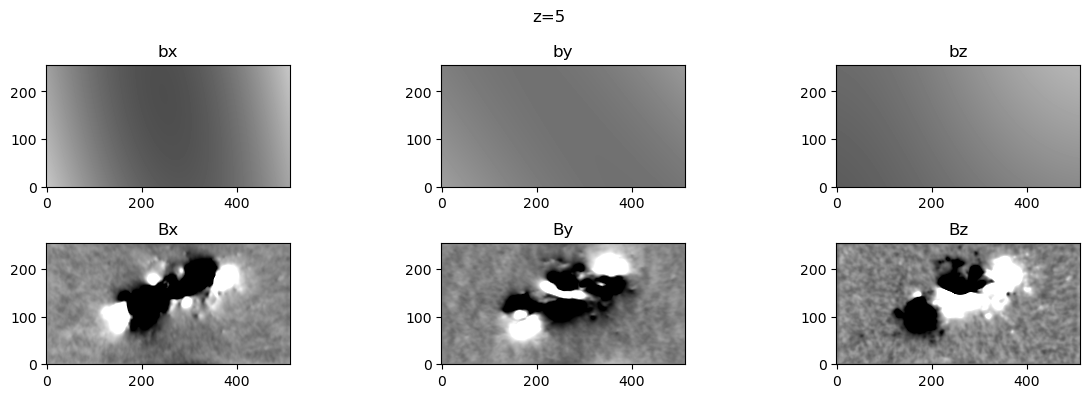

In [36]:
plot_overview(b, b_slices, z=5, b_norm=100)